# 0. Introduction
Instead of using the raw features that we have at hand, an alternative approach is to try to learn useful features $\phi(\mathbf{x})$ from the input data and solve the classification problem in latent space. That is, we can create an adaptive basis funcrion model (ABF), which is a model of the form $$f(\mathbf{x})=w_0+\sum_{m=1}^{M}{w_m\phi_m(\mathbf{x};\mathbf{v}_m)}$$

Where $\phi_m(\mathbf{x};\mathbf{v}_m)$ is the $m$'th basis function learned from the data, parameterized by $\mathbf{v}_m$.

One such model is a feedforward neural network (aka multi-layer perceptron - MLP), which is a series of stacked perceptron units whose outputs are passed through non-linear activation functions (i.e. nodes in the network). Since we are dealing with multi-class classification problem, our model will have the following form: $$p(y|\mathbf{x}, \mathbf{\theta}) = \text{Cat}(y|\mathcal{S}(\mathbf{W}\phi(\mathbf{x}, \mathbf{V})))$$

Where $\mathcal{S}$ is the Softmax function, $\phi(\mathbf{x}, \mathbf{V})$ is a hidden layer, $\mathbf{V}$ is the weight matrix from the inputs to the hidden nodes and $\mathbf{W}$ is a weight matrix from the hidden nodes to the output.

It should be noted that in this notebook, we will deviate from our standard experimental approach in evaluating the models on eight different datasets, mainly because neural networks are universal function approximators, making less assumptions about the data and being less affected by high dimensionality of the features, multicolinearity etc. The hierarchical nature of neural network architectures allows them to automatically learn relevant features from the data, and even disregard redundant/irrelevant input features.
Therefore we will only optimize one model trained on the all_modified dataset and one model on the spectral_modified dataset (we chose modified datasets instead of original datasets, mainly because of the preprocessing done to address the class imbalance)

In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, FunctionTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy, Precision, Recall, AUC
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Accuracy, Precision, Recall

import utils.datasets_utils as datasets_utils
import utils.classification_utils as classification_utils

sns.set_palette("Set2")
sns.set_style("whitegrid")

In [2]:
datasets = datasets_utils.load_datasets()
sub_datasets = filter(lambda x: x.name in {'spectral_modified', 'all_modified'}, datasets)
datasets_wrapper = datasets_utils.DatasetsWrapper(list(sub_datasets))

In [3]:
datasets_wrapper.get_shapes()

,train_X,val_X,test_X,train_y,val_y,test_y
spectral_modified,"(23114, 189)","(2397, 189)","(5993, 189)","(23114,)","(2397,)","(5993,)"
all_modified,"(23114, 287)","(2397, 287)","(5993, 287)","(23114,)","(2397,)","(5993,)"


# 1. Data preparation

As opposed to other models that are invariant to the scale of the features, we have to scale the data before using the MLP model, mainly to avoid saturating the activation functions.

In [4]:
# scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = StandardScaler()
datasets_wrapper.scale_datasets(scaler)

Since we have 16 unique genres that we are trying to predict, we will have 16 neurons in the last layer of the network. Considering that our target column is nominal, we need to one-hot encode it, for it to be compatible with the model's architecture.

In [5]:
def oh_encode_target(train_y, val_y, test_y, handle_unknown):
  train_y = train_y.copy().to_frame()
  val_y = val_y.copy().to_frame()
  test_y = test_y.copy().to_frame()
  encoder = OneHotEncoder(sparse_output=False, handle_unknown=handle_unknown)

  encoder.fit(train_y)
  oh_train = pd.DataFrame(encoder.transform(train_y), index=train_y.index, columns=encoder.get_feature_names_out(), dtype='int64')
  oh_val   = pd.DataFrame(encoder.transform(val_y), index=val_y.index, columns=encoder.get_feature_names_out(), dtype='int64')
  oh_test  = pd.DataFrame(encoder.transform(test_y), index=test_y.index, columns=encoder.get_feature_names_out(), dtype='int64')

  return oh_train, oh_val, oh_test, encoder.get_feature_names_out()

In [6]:
spectral_modified = datasets_wrapper.get_dataset('spectral_modified')
all_modified = datasets_wrapper.get_dataset('all_modified')

In [7]:
# Saving the original target columns before applying OH encoding
spectral_train_y_original = spectral_modified.train.y.copy()
spectral_val_y_original = spectral_modified.val.y.copy()
spectral_test_y_original = spectral_modified.test.y.copy()

all_train_y_original = all_modified.train.y.copy()
all_val_y_original = all_modified.val.y.copy()
all_test_y_original = all_modified.test.y.copy()

In [8]:
spectral_modified.train.y, spectral_modified.val.y, spectral_modified.test.y, class_names_spectral = oh_encode_target(spectral_modified.train.y, spectral_modified.val.y, spectral_modified.test.y, 'error')
all_modified.train.y, all_modified.val.y, all_modified.test.y, class_names_all = oh_encode_target(all_modified.train.y, all_modified.val.y, all_modified.test.y, 'error')

# 2. Training

## 2.1. Spectral Dataset

In [9]:
spectral_model = Sequential([
    Dense(units=256, activation='relu', input_shape=[len(spectral_modified.train.X.columns)]),
    Dropout(0.2),
    BatchNormalization(),
    Dense(units=256, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(units=128, activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    BatchNormalization(),
    Dense(units=64, activation='relu'),
    BatchNormalization(),
    Dense(units=32, activation='relu'),
    Dense(units=16, activation='softmax')
])

In [10]:
spectral_model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
)

In [11]:
tf.random.set_seed(23)

spectral_history = spectral_model.fit(
    x=spectral_modified.train.X, y=spectral_modified.train.y,
    validation_data=(spectral_modified.val.X, spectral_modified.val.y),
    batch_size=64,
    epochs=150,
    shuffle=True,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
    ],
)

Epoch 1/150


362/362 [==============================] - 3s 4ms/step - loss: 1.8366 - val_loss: 1.3717
Epoch 2/150
362/362 [==============================] - 1s 4ms/step - loss: 1.4749 - val_loss: 1.3181
Epoch 3/150
362/362 [==============================] - 1s 3ms/step - loss: 1.3622 - val_loss: 1.3005
Epoch 4/150
362/362 [==============================] - 1s 4ms/step - loss: 1.2782 - val_loss: 1.2880
Epoch 5/150
362/362 [==============================] - 1s 4ms/step - loss: 1.2186 - val_loss: 1.2658
Epoch 6/150
362/362 [==============================] - 1s 4ms/step - loss: 1.1624 - val_loss: 1.2525
Epoch 7/150
362/362 [==============================] - 1s 4ms/step - loss: 1.1210 - val_loss: 1.2276
Epoch 8/150
362/362 [==============================] - 1s 4ms/step - loss: 1.0735 - val_loss: 1.2447
Epoch 9/150
362/362 [==============================] - 1s 4ms/step - loss: 1.0378 - val_loss: 1.2321
Epoch 10/150
362/362 [==============================] - 1s 4ms/step - loss: 0.9991 - val_loss: 1.2307
E

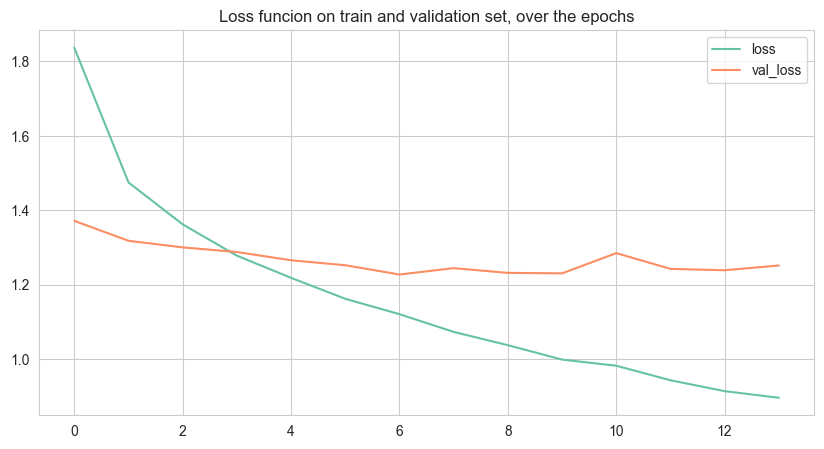

In [12]:
spectral_history_df = pd.DataFrame(spectral_history.history)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
spectral_history_df.plot(ax=ax)
plt.title('Loss funcion on train and validation set, over the epochs')
plt.show()

## 2.2. All Features Dataset

In [13]:
all_model = Sequential([
    Dense(units=128, activation='relu', input_shape=[len(all_modified.train.X.columns)]),
    Dropout(0.2),
    BatchNormalization(),
    Dense(units=256, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(units=128, activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    BatchNormalization(),
    Dense(units=64, activation='relu'),
    BatchNormalization(),
    Dense(units=32, activation='relu'),
    Dense(units=16, activation='softmax')
])

In [14]:
all_model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
)

In [15]:
tf.random.set_seed(23)

all_history = all_model.fit(
    x=all_modified.train.X, y=all_modified.train.y,
    validation_data=(all_modified.val.X, all_modified.val.y),
    batch_size=64,
    epochs=150,
    shuffle=True,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
    ],
)

Epoch 1/150


362/362 [==============================] - 3s 4ms/step - loss: 1.8851 - val_loss: 1.4353
Epoch 2/150
362/362 [==============================] - 1s 3ms/step - loss: 1.5050 - val_loss: 1.3510
Epoch 3/150
362/362 [==============================] - 1s 3ms/step - loss: 1.3843 - val_loss: 1.3266
Epoch 4/150
362/362 [==============================] - 1s 3ms/step - loss: 1.3065 - val_loss: 1.3198
Epoch 5/150
362/362 [==============================] - 1s 3ms/step - loss: 1.2501 - val_loss: 1.2913
Epoch 6/150
362/362 [==============================] - 1s 4ms/step - loss: 1.2021 - val_loss: 1.2999
Epoch 7/150
362/362 [==============================] - 1s 3ms/step - loss: 1.1547 - val_loss: 1.2549
Epoch 8/150
362/362 [==============================] - 1s 3ms/step - loss: 1.1177 - val_loss: 1.2873
Epoch 9/150
362/362 [==============================] - 1s 3ms/step - loss: 1.0746 - val_loss: 1.2682
Epoch 10/150
362/362 [==============================] - 1s 3ms/step - loss: 1.0528 - val_loss: 1.2477
E

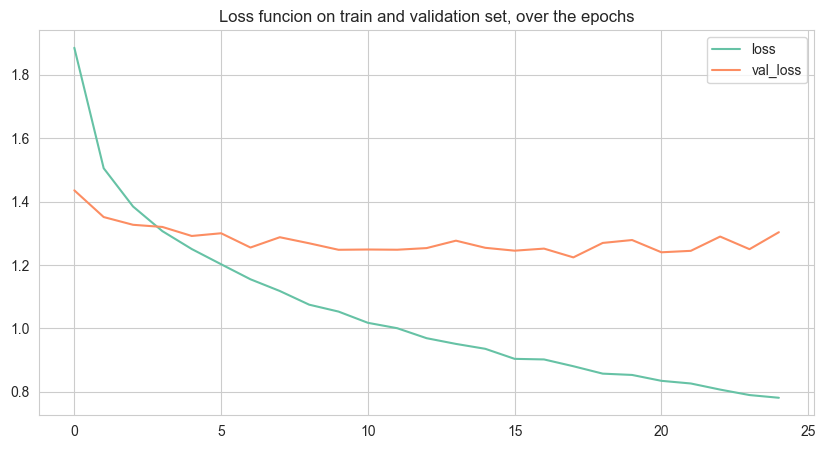

In [16]:
all_history_df = pd.DataFrame(all_history.history)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
all_history_df.plot(ax=ax)
plt.title('Loss funcion on train and validation set, over the epochs')
plt.show()

# 3. Evaluation

In [17]:
# to be able to use it in the ClassificationEvaluation class
class MLPClassifierWrapper:
    def __init__(self, model, class_names):
        self.model = model
        self.class_names = list(map(lambda x: x[3:], class_names))

    def predict(self, X):
        y_pred = np.argmax(self.model.predict(X, verbose=0), axis=1)
        y_pred = [self.class_names[i] for i in y_pred]
        return y_pred

def get_max_proba_prediction(model, X, class_names):
    y_pred = model.predict(X, verbose=0)

    # the list contains the pairs (probability, label) for each row in the dataframe
    list_tuples = list(pd.DataFrame(y_pred).apply(lambda r: (np.max(r), class_names[np.argmax(r)][3:]), axis=1))
    return pd.DataFrame(list_tuples, columns=['probability', 'label'])

In [18]:
# Reverting from OH encoded target to original
spectral_modified.train.y = spectral_train_y_original
spectral_modified.val.y = spectral_val_y_original
spectral_modified.test.y = spectral_test_y_original

all_modified.train.y = all_train_y_original
all_modified.val.y = all_val_y_original
all_modified.test.y = all_test_y_original

In [19]:
spectral_classifier = classification_utils.ClassifierFactory.create_instance(
    dataset=spectral_modified,
    classifier=MLPClassifierWrapper(model=spectral_model, class_names=class_names_spectral),
)

all_classifier = classification_utils.ClassifierFactory.create_instance(
    dataset=all_modified,
    classifier=MLPClassifierWrapper(model=all_model, class_names=class_names_all),
)

In [20]:
cl_collection = classification_utils.ClassifiersCollection([spectral_classifier, all_classifier])
cl_collection.evaluate_classifiers()

spectral_modified                     all_modified  \
                                 train       val      test        train   
accuracy                      0.729558  0.621193  0.611881     0.824652   
precision (weighted)          0.729858  0.639640  0.627421     0.826118   
recall (weighted)             0.729558  0.621193  0.611881     0.824652   
f1 (weighted)                 0.727099  0.627295  0.616449     0.824422   

                                          
                           val      test  
accuracy              0.622028  0.619056  
precision (weighted)  0.652376  0.650596  
recall (weighted)     0.622028  0.619056  
f1 (weighted)         0.631339  0.627717

## 3.1 Spectral Features Dataset

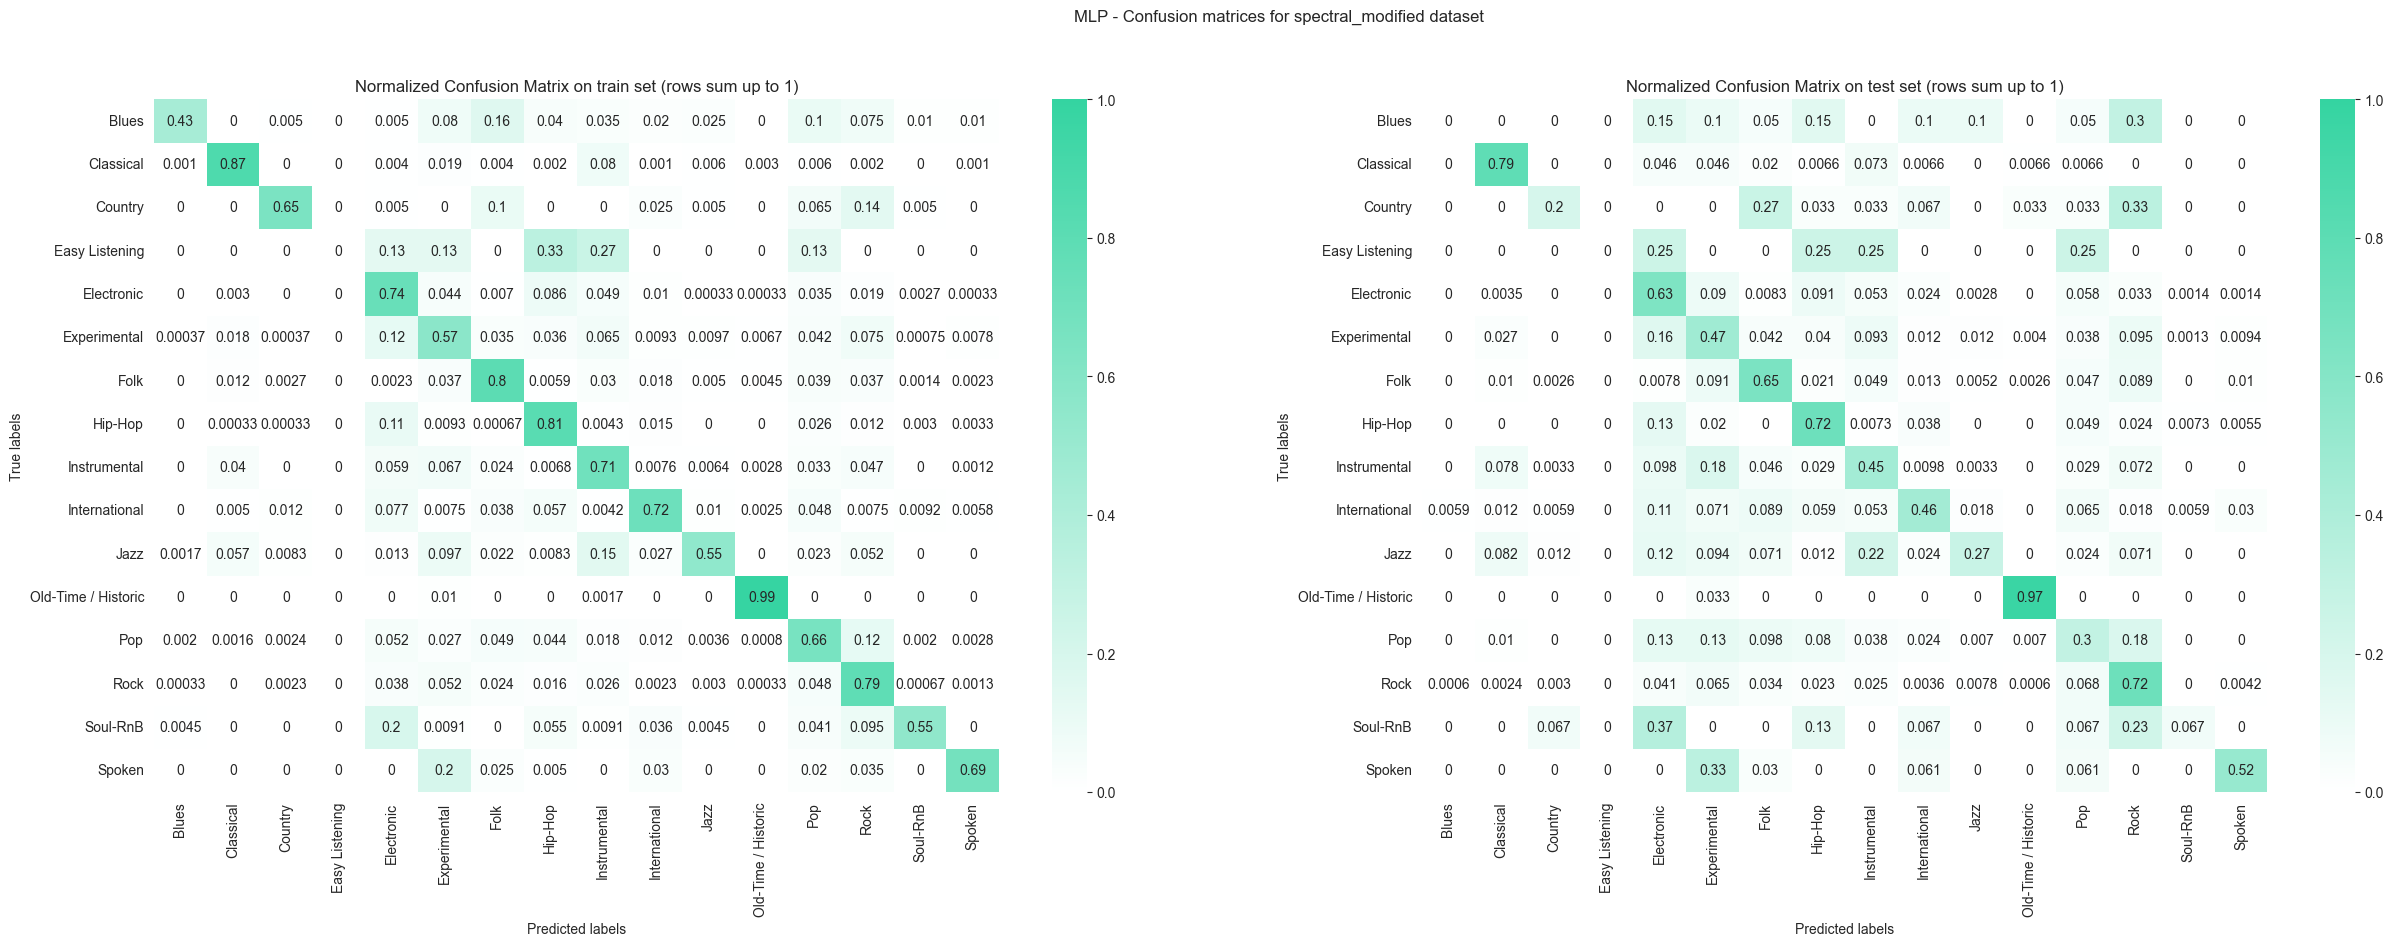

In [21]:
fig, axis = plt.subplots(1, 2, figsize=(30, 9))
spectral_classifier.get_clf_evaluation().plot_confusion_matrix(ax=axis[0], on_set='train')
spectral_classifier.get_clf_evaluation().plot_confusion_matrix(ax=axis[1], on_set='test')
fig.suptitle('MLP - Confusion matrices for spectral_modified dataset')
plt.show()

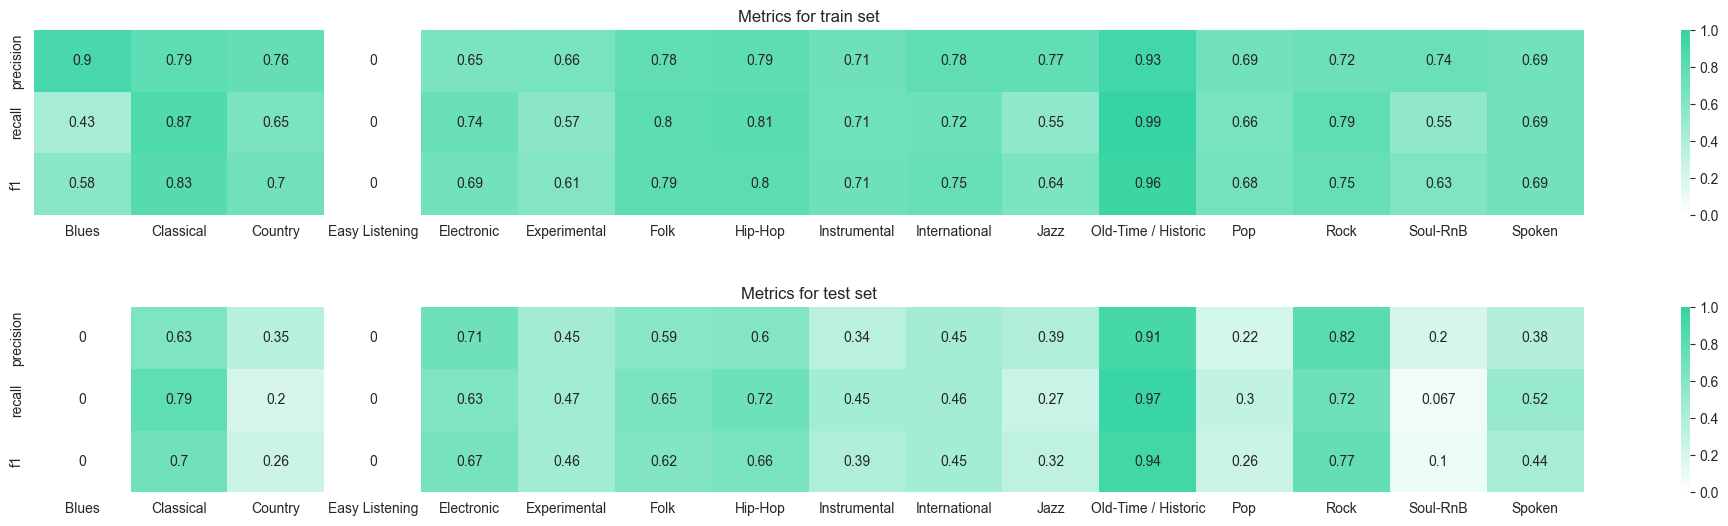

In [22]:
_, ax = plt.subplots(2, 1, figsize=(25, 6))
spectral_classifier.get_clf_evaluation().plot_metrics_per_class(ax=ax[0], on_set='train')
spectral_classifier.get_clf_evaluation().plot_metrics_per_class(ax=ax[1], on_set='test')
plt.subplots_adjust(hspace=0.5)
plt.show()

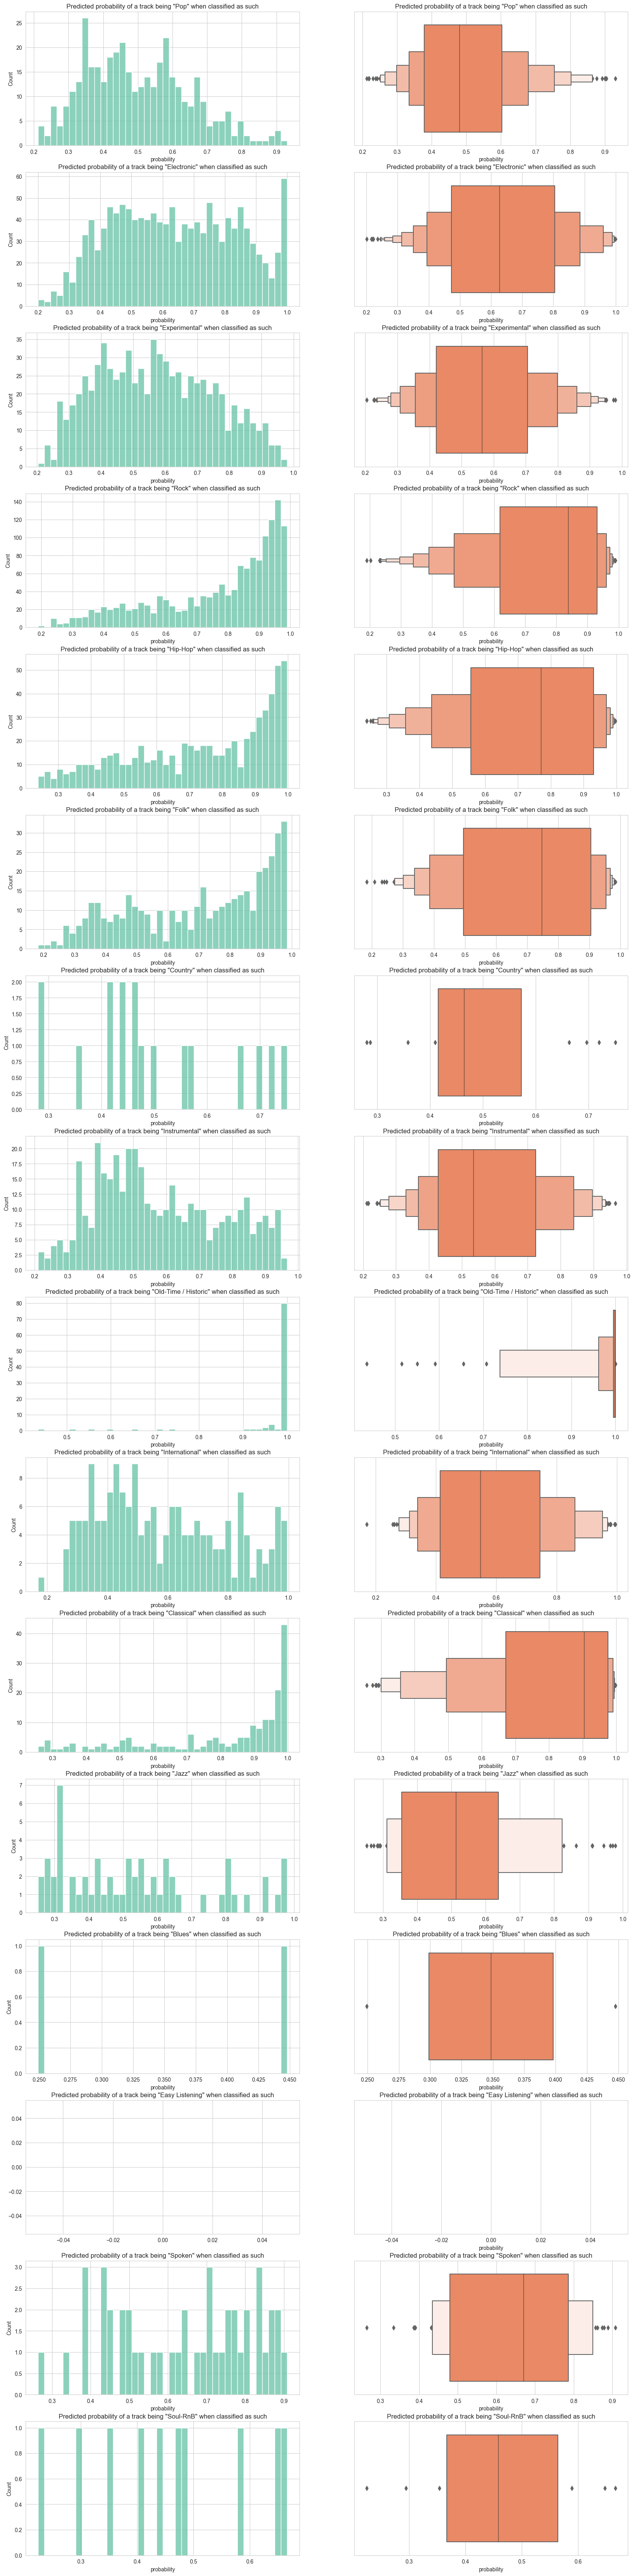

In [23]:
num_genres = 16
spectral_predicted_proba = get_max_proba_prediction(spectral_model, spectral_modified.test.X, class_names_spectral)
ax_idxs = [(i, j) for i in range(num_genres) for j in range(2)]

fig, axs = plt.subplots(num_genres, 2, figsize=(20, 85))

k = 0
for genre in spectral_test_y_original.unique():
    ax1_idx, ax2_idx = ax_idxs[k], ax_idxs[k + 1]
    ax1, ax2 = axs[ax1_idx[0]][ax1_idx[1]], axs[ax2_idx[0]][ax2_idx[1]]

    ax1.set_title(f'Predicted probability of a track being "{genre}" when classified as such')
    ax2.set_title(f'Predicted probability of a track being "{genre}" when classified as such')

    sns.histplot(x=spectral_predicted_proba[spectral_predicted_proba['label'] == genre]['probability'], bins=40, ax=ax1)
    sns.boxenplot(x=spectral_predicted_proba[spectral_predicted_proba['label'] == genre]['probability'], color='coral', ax=ax2)
    k += 2

## 3.2 All Features Dataset

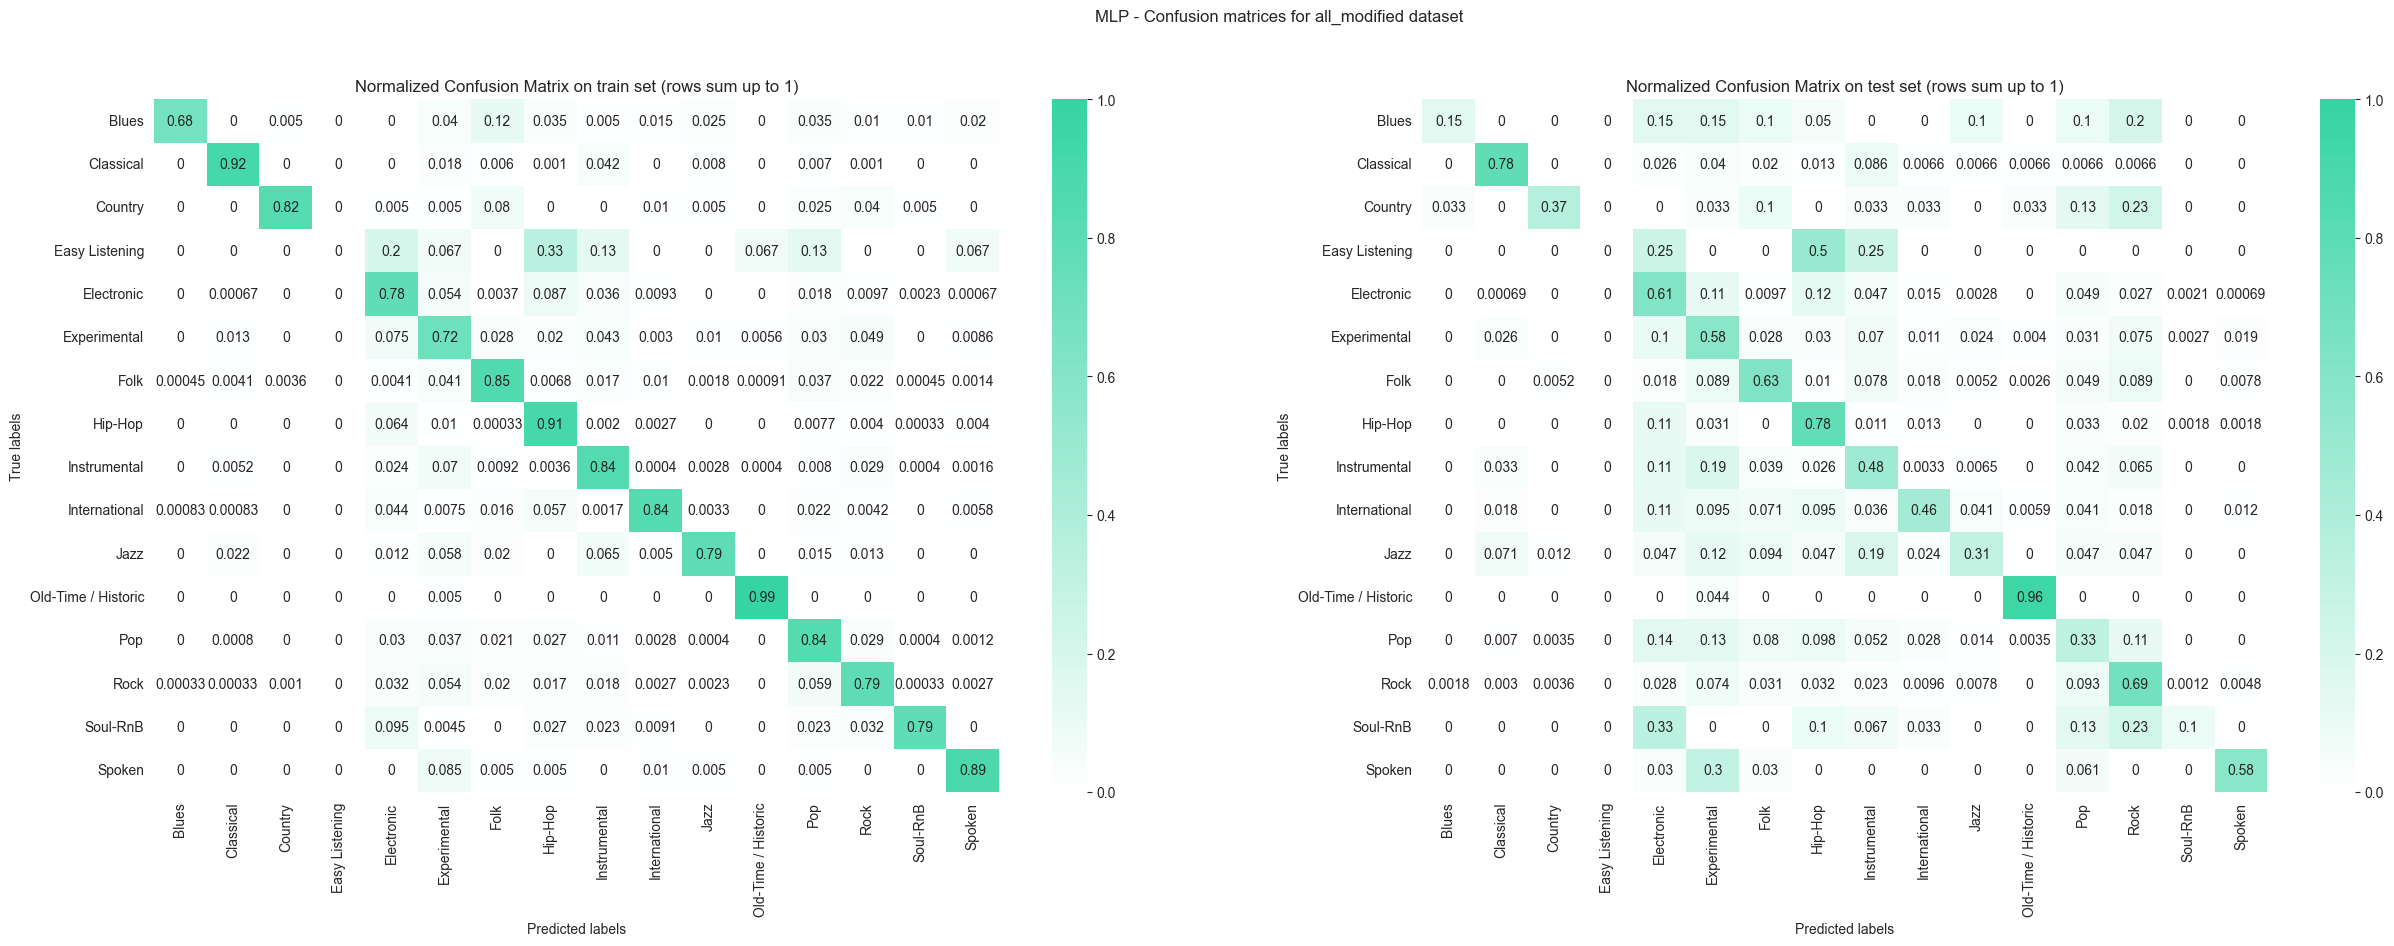

In [24]:
fig, axis = plt.subplots(1, 2, figsize=(30, 9))
all_classifier.get_clf_evaluation().plot_confusion_matrix(ax=axis[0], on_set='train')
all_classifier.get_clf_evaluation().plot_confusion_matrix(ax=axis[1], on_set='test')
fig.suptitle('MLP - Confusion matrices for all_modified dataset')
plt.show()

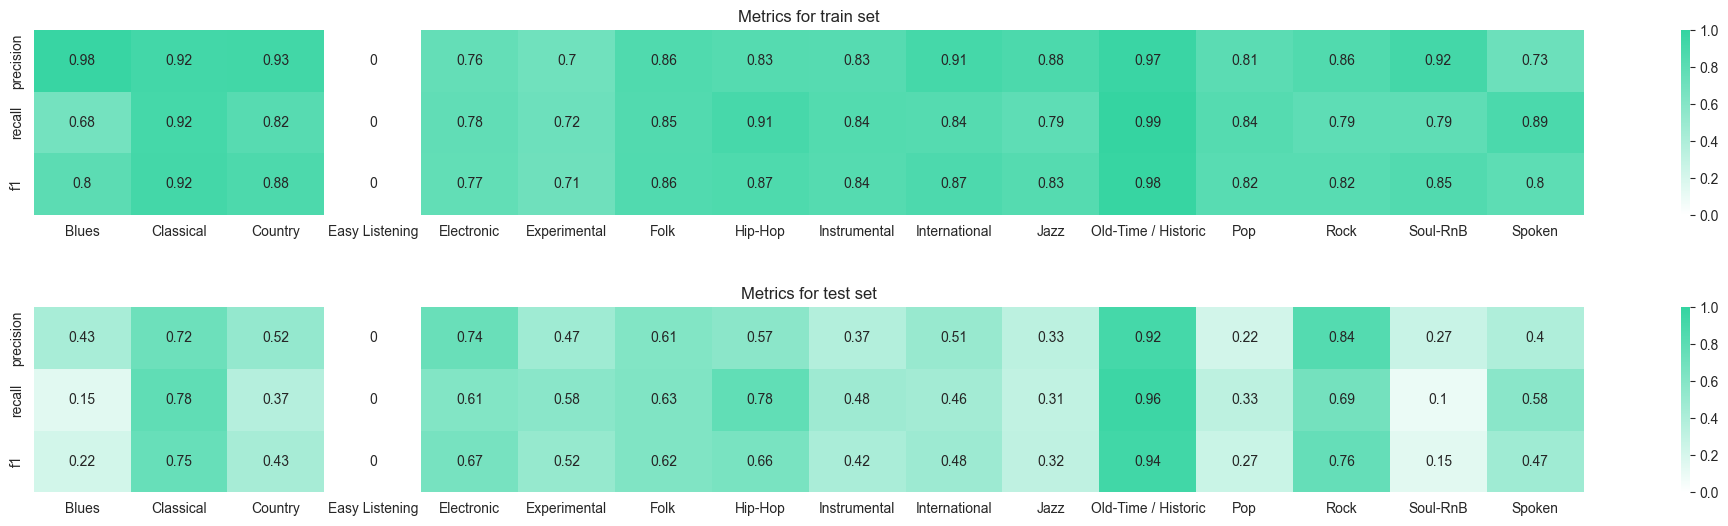

In [25]:
_, ax = plt.subplots(2, 1, figsize=(25, 6))
all_classifier.get_clf_evaluation().plot_metrics_per_class(ax=ax[0], on_set='train')
all_classifier.get_clf_evaluation().plot_metrics_per_class(ax=ax[1], on_set='test')
plt.subplots_adjust(hspace=0.5)
plt.show()

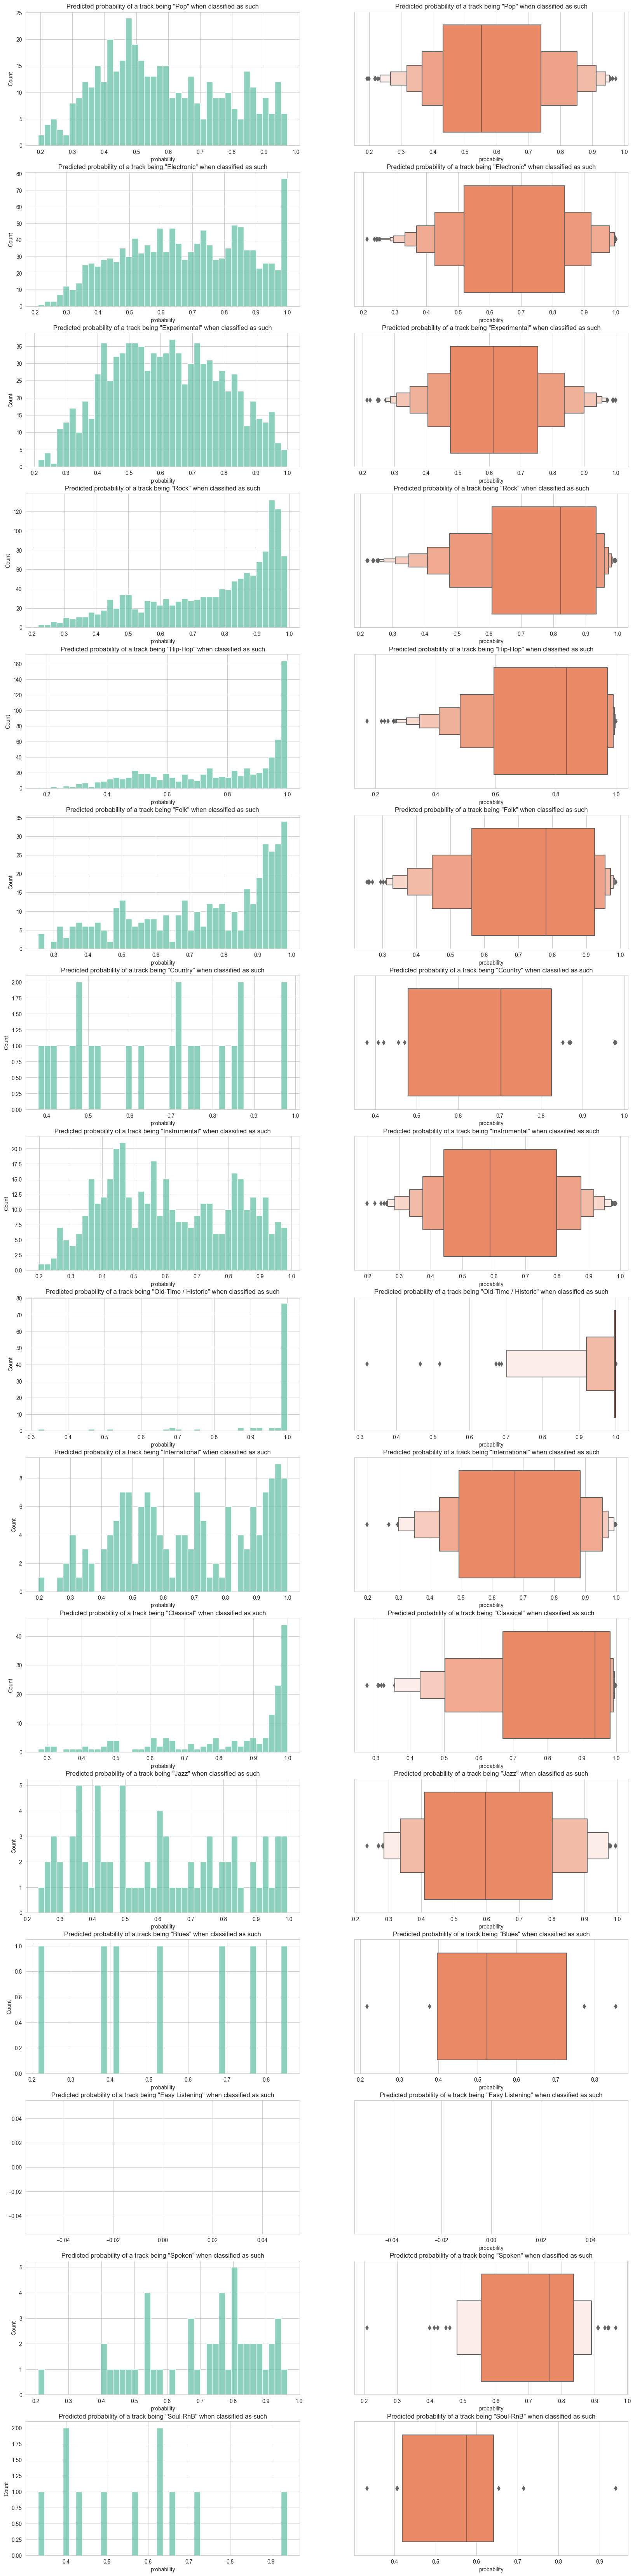

In [26]:
num_genres = 16
all_predicted_proba = get_max_proba_prediction(all_model, all_modified.test.X, class_names_all)
ax_idxs = [(i, j) for i in range(num_genres) for j in range(2)]

fig, axs = plt.subplots(num_genres, 2, figsize=(20, 85))

k = 0
for genre in all_test_y_original.unique():
    ax1_idx, ax2_idx = ax_idxs[k], ax_idxs[k + 1]
    ax1, ax2 = axs[ax1_idx[0]][ax1_idx[1]], axs[ax2_idx[0]][ax2_idx[1]]

    ax1.set_title(f'Predicted probability of a track being "{genre}" when classified as such')
    ax2.set_title(f'Predicted probability of a track being "{genre}" when classified as such')

    sns.histplot(x=all_predicted_proba[all_predicted_proba['label'] == genre]['probability'], bins=40, ax=ax1)
    sns.boxenplot(x=all_predicted_proba[all_predicted_proba['label'] == genre]['probability'], color='coral', ax=ax2)
    k += 2